In [30]:
from skimage.io import imread
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from random import shuffle

import os
import glob
from tqdm import tqdm

from util import load_positive_samples, load_negative_samples

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
positive_samples = load_positive_samples()
negative_samples = load_negative_samples()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 70/70 [00:16<00:00,  3.45it/s]


In [6]:
def plot_img(samples, select_num=6):   
    num_samples = len(samples)
    selected_index = np.random.choice(num_samples, select_num, replace=True)
    
    count = 0
    for index in selected_index:
        count += 1     
        plt_idx = count
        plt.subplot(1, select_num, plt_idx)
        plt.imshow(samples[index])
        plt.axis('off')
        
    plt.show()

15168


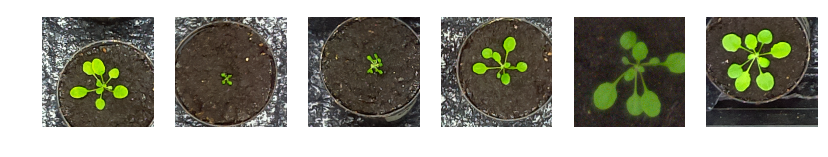

In [9]:
print(len(positive_samples))
plot_img(positive_samples)

19312


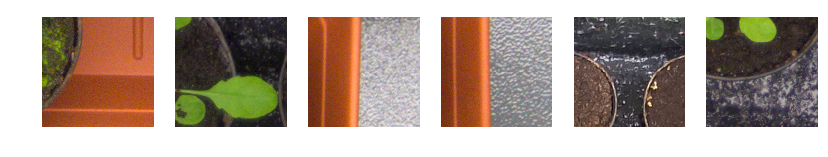

In [8]:
print(len(negative_samples))
plot_img(negative_samples)

In [17]:
from sklearn.model_selection import train_test_split

labels = []
fds = []
for sample in positive_samples:
    sample = np.transpose(sample)
    fds.append(sample[:3,:,:])
    labels.append([1, 0])

shuffle(negative_samples)
for sample in negative_samples:
    sample = np.transpose(sample)
    fds.append(sample[:3,:,:])
    labels.append([0, 1])

X_train, X_test, y_train, y_test = train_test_split(
    fds, labels, test_size=0.2, random_state=0)

## Training

In [ ]:
from squeezenet import SqueezeNet, ConvNet

# here you can switch between different CNN model
model, callback_list = ConvNet(nb_classes=2)
hist = model.fit(np.array(X_train), np.array(y_train), batch_size=32, epochs=3, verbose=1, 
                callbacks=callback_list, validation_split=0.2, validation_data=None, 
                shuffle=True, initial_epoch=0)

In [18]:
from squeezenet import SqueezeNet, ConvNet

# here you can switch between different CNN model
model, callback_list = SqueezeNet(nb_classes=2)
hist = model.fit(np.array(X_train), np.array(y_train), batch_size=32, epochs=2, verbose=1, 
                callbacks=callback_list, validation_split=0.2, validation_data=None, 
                shuffle=True, initial_epoch=0)

squeezeNet model summary: 
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3, 224, 224)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 96, 112, 112)  14208                                        
____________________________________________________________________________________________________
maxpool1 (MaxPooling2D)          (None, 96, 55, 55)    0                                            
____________________________________________________________________________________________________
fire2_squeeze (Conv2D)           (None, 16, 55, 55)    1552                                         
________________________________________________________________

## Evaluate

In [32]:
model.evaluate(np.array(X_test), np.array(y_test), batch_size=32, verbose=1, sample_weight=None)

6896/6896 [==============================] - 25s    


[0.029751360487720115, 0.99463457076566131]

## Testing

In [31]:
from squeezenet import SqueezeNet, ConvNet
model, callback_list = ConvNet(nb_classes=2, is_testing=True)

# Precision, Recall, F1

In [27]:
pred = model.predict(np.array(X_test))

tp = 0
tn = 0
fp = 0
fn = 0

for i, score in enumerate(pred):
    if score[0] > score[1]:
        if y_test[i] == [1, 0]:
            tp += 1
        else:
            fp += 1
    
    else:
        if y_test[i] == [0, 1]:
            tn += 1
        else:
            fn += 1
    

print('precision: ', float(tp/(tp+fp)))
print('recall: ', float(tp/(tp+fn)))
print('f1: ', float(2*tp/(2*tp+fn+fp)))

precision:  0.987571380584481
recall:  1.0
f1:  0.9937468311644414


## Object Detection

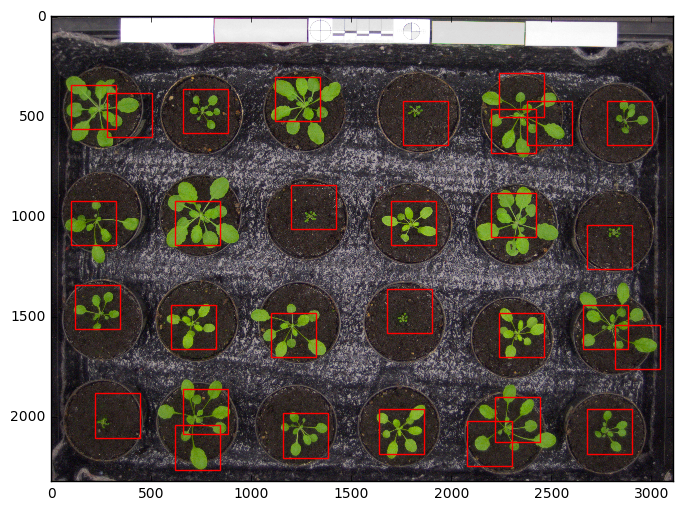

In [22]:
from util import nms
from util import sliding_window

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x[0]) / np.sum(np.exp(x))

min_window_size = (224, 224)
step_size = (20, 20)
confidence_threshold = 0.70
threshold = 0.1

detections = []

current_path = os.getcwd()
# img_path = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2012', 'ara2012_tray01_rgb.png')
img_path = os.path.join(current_path, 'Datasets', 'Tray', 'Ara2013-Canon', 'ara2013_tray20_rgb.png')
im = imread(img_path)

candidate_imgs = []
coordinates = []
for (x, y, im_window) in sliding_window(im, min_window_size, step_size):
        if im_window.shape[0] != min_window_size[0] or im_window.shape[1] != min_window_size[1]:
            continue
        candidate_imgs.append(np.transpose(im_window))
        coordinates.append([x, y])

candidate_imgs = np.array(candidate_imgs)
pred = model.predict(candidate_imgs)

for i, score in enumerate(pred):
    confidence = softmax(score)
    if confidence > confidence_threshold:
        detections.append((coordinates[i][0], coordinates[i][1], confidence,
            int(min_window_size[0]),
            int(min_window_size[1])))

# Display the results before performing NMS
clone = im.copy()

# Perform Non Maxima Suppression
left_detections = nms(detections, threshold)

# Create figure and axes
fig, ax = plt.subplots(1)

# Display the image
ax.imshow(clone)

# Display the results after performing NMS
for (x_tl, y_tl, _, w, h) in left_detections:
    # Draw the detections
    rect = patches.Rectangle((x_tl, y_tl), w, h, linewidth=1,edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
plt.show()